# Imports and Defaults

In [1]:
import json
import os
from functools import lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(font_scale=1.6, style="whitegrid")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "figure.dpi": 300,
})

seed = 1234
rng = np.random.default_rng(seed)
funnel_dim = 50

# Load Data

In [3]:
# posterior_fname = f"../../data/funnel{funnel_dim}/baseline"
posterior_fname = f"../../data/rosenbrock2/baseline"

drghmc_sampler = "adapt_metric=False__damping=0.08__max_proposals=3__metric=1__probabilistic=False__reduction_factor=4__sampler_type=drghmc__step_count_method=const_step_count__step_size_factor=2"
drhmc_sampler = "adapt_metric=False__damping=1.0__max_proposals=3__metric=1__probabilistic=False__reduction_factor=4__sampler_type=drhmc__step_count_factor=0.9__step_size_factor=2"
nuts_sampler = "adapt_metric=False__metric=identity__sampler_type=nuts"

In [4]:
def get_fname(sampler, chain):
    return os.path.join(posterior_fname, sampler, f"history__chain={chain}.npz")

def get_chain_data(sampler, chain, downsample=1):
    data = np.load(get_fname(sampler, chain))
    return data["draws"][::downsample], data["grad_evals"][::downsample]

In [5]:
@lru_cache(maxsize=3)
def get_data(sampler):
    data_list, grad_list = [], []
    for chain in range(100):
        draws, grad_evals = get_chain_data(sampler, chain)
        data_list.append(draws)
        grad_list.append(np.array(grad_evals))
    
    return data_list, grad_list

In [6]:
drghmc_data, drghmc_grads = get_data(drghmc_sampler)
drhmc_data, drhmc_grads = get_data(drhmc_sampler)
nuts_data, nuts_grads = get_data(nuts_sampler)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/rosenbrock2/baseline/adapt_metric=False__damping=0.08__max_proposals=3__metric=1__probabilistic=False__reduction_factor=4__sampler_type=drghmc__step_count_method=const_step_count__step_size_factor=2/history__chain=0.npz'

In [ ]:
# drghmc in 10 dim has 1e7 grad evals, instead of 1e6
if funnel_dim == 10:    
    for i in range(len(drghmc_grads)):
        idx = np.where(drghmc_grads[i] < 1e6)[0]
        drghmc_data[i] = drghmc_data[i][idx]
        drghmc_grads[i] = drghmc_grads[i][idx]

In [ ]:
np.set_printoptions(precision=4)

for d in [drghmc_data, drhmc_data, nuts_data]:
    d_mean = np.mean(np.concatenate(d, axis=0), axis=0)
    d_std = np.std(np.concatenate(d, axis=0), axis=0)
    print(f"Mean: {d_mean[0]}\tStd: {d_std[0]}")

Mean: 0.07924022484768367	Std: 2.9929705173042636
Mean: 0.6802256168101438	Std: 2.7450470661128143
Mean: 0.29328751443044154	Std: 2.525950331556801


# Loss Plots

In [ ]:
fname = f"../../posteriors/funnel{funnel_dim}/funnel{funnel_dim}.analytic_params.json"
with open(fname, "r") as f:
    analytic_params = json.load(f)
    
true_mean = np.array([v for v in analytic_params["params_mean"].values()])
true_std = np.array([v for v in analytic_params["params_std"].values()])
true_squared_mean = np.array([v for v in analytic_params["params_squared_mean"].values()])
true_squared_std = np.array([v for v in analytic_params["params_squared_std"].values()])

In [ ]:
# dummy data
ndim = 2
nchains = 3
nsamples = 5

data = [rng.integers(0, 10, (nsamples, ndim)) for _ in range(nchains)]
grads = [np.cumsum(rng.integers(1, 10, nsamples)) for _ in range(nchains)]

# _ = [print(f"Data: {d}\nGrad: {g}\n") for d, g in zip(data, grads)]

In [ ]:
# compute cumulative average based off gradeint evaluation indexing across chains
# for `t` gradient evaluations, we want to get the average of all samples across all chains 
# generated with <= t gradient evaluations

# merge data list into single numpy array based off gradient evaluation index
# do so effiicently because single chain data is already sorted per gradient evaluation
def merge_data(data_list, grad_list):
    data = np.concatenate(data_list, axis=0)
    grads = np.concatenate(grad_list, axis=0)
    idx = np.argsort(grads)
    return data[idx], grads[idx]

# merged_data, merged_grads = merge_data(data, grads)
# _ = [print(f"Data: {d}\tGrad: {g}") for d, g in zip(merged_data, merged_grads)]

In [ ]:
def get_mean(data):
    n = data.shape[0]
    denom = np.arange(1, n + 1)[:, None]
    return np.cumsum(data, axis=0) / denom
    
def get_error(data):
    abs_error = np.abs(get_mean(data) - true_mean)
    abs_error = abs_error[:, 0][:, None]
    return np.linalg.norm(abs_error / true_std, axis=1, ord=np.inf)  # inf norm equivalent to max

def get_error_squared(data):
    abs_error = np.abs(get_mean(data ** 2) - true_squared_mean)
    abs_error = abs_error[:, 0][:, None]
    return np.linalg.norm(abs_error / true_squared_std, axis=1, ord=np.inf)  # inf norm equivalent to max

# np.set_printoptions(precision=3)
# avg = get_mean(merged_data)
# _ = [print(f"Data: {d}   \tGrad: {g}") for d, g in zip(avg, merged_grads)]

In [ ]:
# try with real data
drghmc_data_merged, drghmc_grad_merged = merge_data(drghmc_data, drghmc_grads)
drhmc_data_merged, drhmc_grad_merged = merge_data(drhmc_data, drhmc_grads)
nuts_data_merged, nuts_grad_merged = merge_data(nuts_data, nuts_grads)

In [ ]:
drghmc_error = get_error(drghmc_data_merged)
drhmc_error = get_error(drhmc_data_merged)
nuts_error = get_error(nuts_data_merged)

drghmc_error_squared = get_error_squared(drghmc_data_merged)
drhmc_error_squared = get_error_squared(drhmc_data_merged)
nuts_error_squared = get_error_squared(nuts_data_merged)

In [ ]:
data = {
    "Gradient Evaluations": np.concatenate([drghmc_grad_merged, drhmc_grad_merged, nuts_grad_merged]),
    "Error": np.concatenate([drghmc_error, drhmc_error, nuts_error]),
    "Error Squared": np.concatenate([drghmc_error_squared, drhmc_error_squared, nuts_error_squared]),
    "Sampler": np.concatenate(
        [["DR-G-HMC"] * len(drghmc_grad_merged), 
         ["DR-HMC"] * len(drhmc_grad_merged), 
         ["NUTS"] * len(nuts_grad_merged)]
    )
}

data = pd.DataFrame(data)
data = pd.melt(data, id_vars=["Gradient Evaluations", "Sampler"], var_name="Error Type", value_name="Errors")
data = data.iloc[::10, :]
data

,Gradient Evaluations,Sampler,Error Type,Errors
0,2.0,DR-G-HMC,Error,0.539788
10,2.0,DR-G-HMC,Error,0.124912
20,2.0,DR-G-HMC,Error,0.214564
30,4.0,DR-G-HMC,Error,0.284229
40,4.0,DR-G-HMC,Error,0.298005
...,...,...,...,...
661650,995938.0,NUTS,Error Squared,0.199873
661660,996939.0,NUTS,Error Squared,0.199460
661670,997587.0,NUTS,Error Squared,0.199355
661680,998099.0,NUTS,Error Squared,0.199493


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


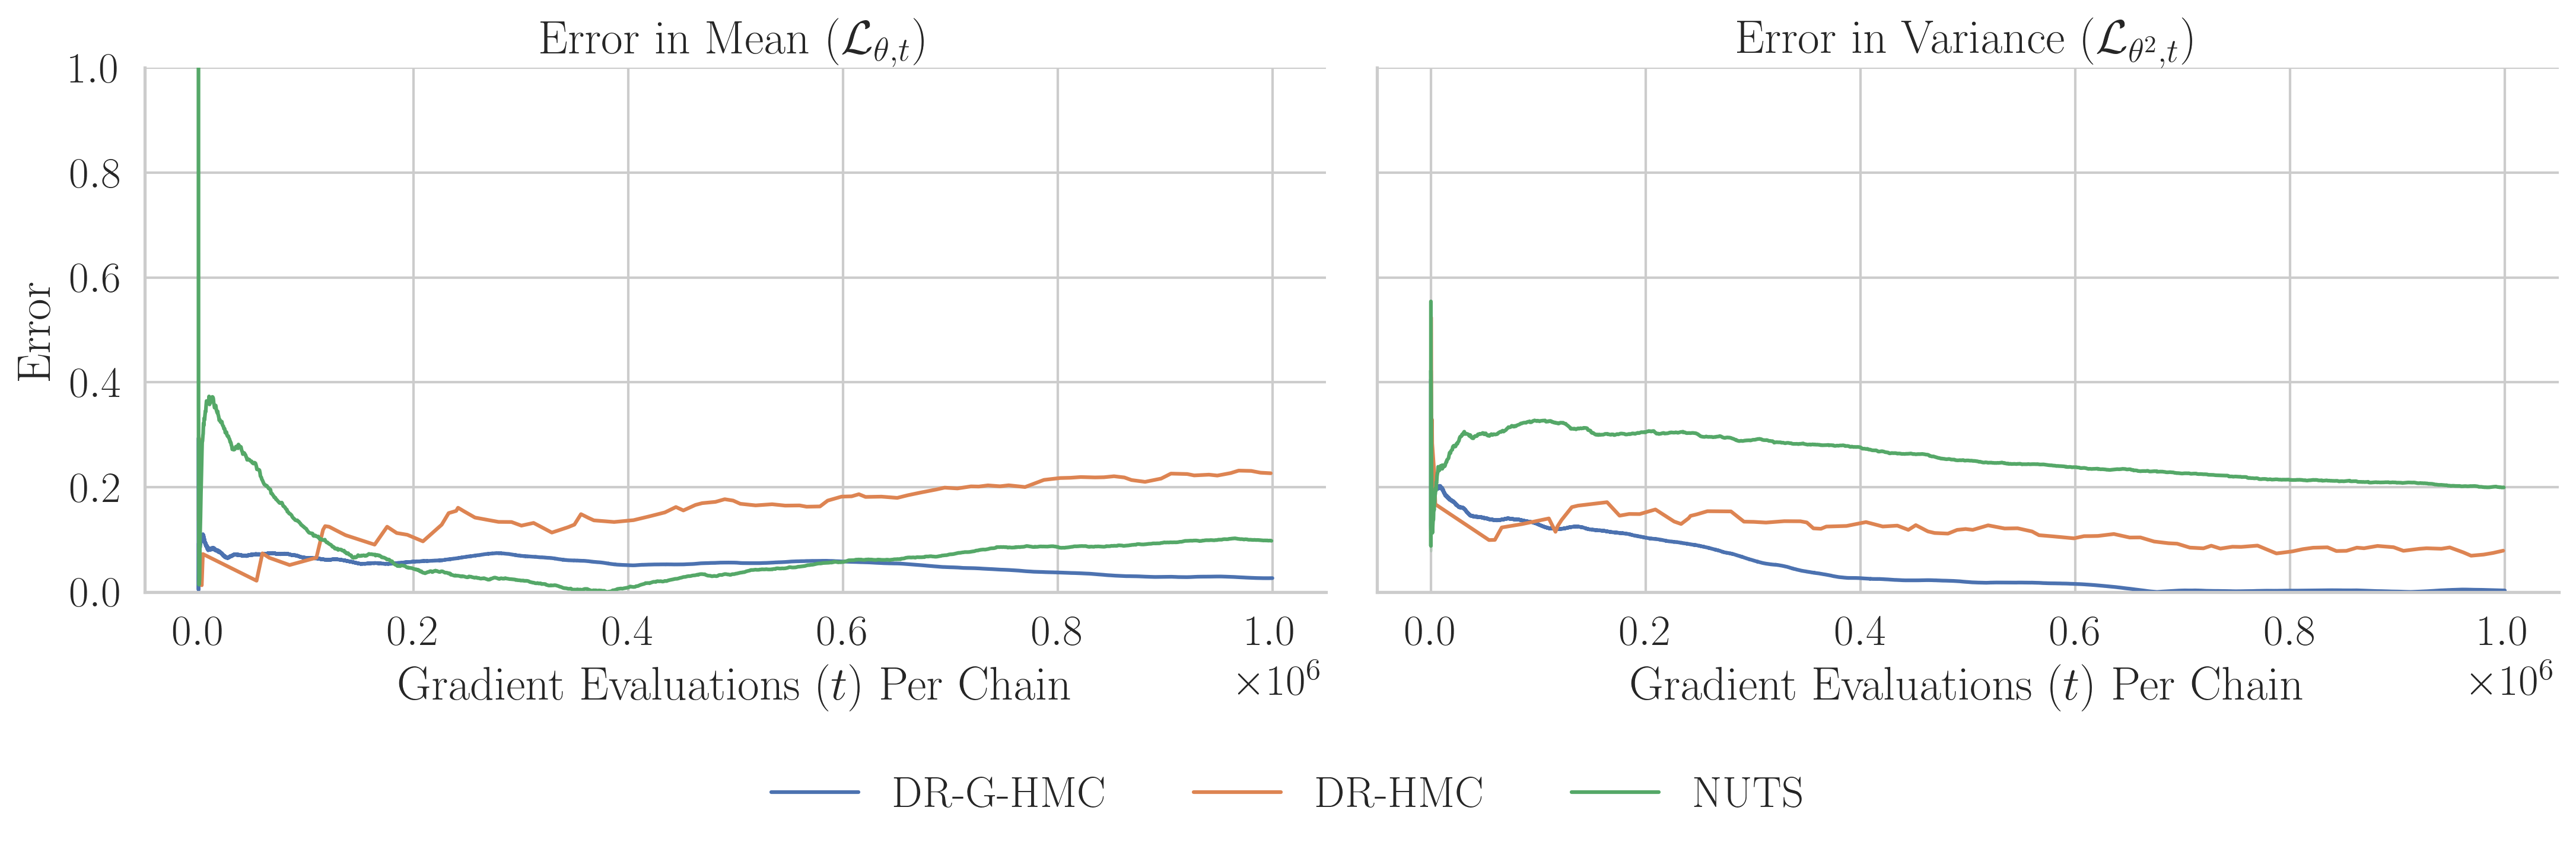

In [ ]:
fig = sns.relplot(
    data=data,
    kind="line",
    x="Gradient Evaluations",
    y="Errors",
    hue="Sampler",
    # row="Sampler",
    col="Error Type",
    aspect=1.5,
    # facet_kws={"sharey": "col"},
)
# fig.set(yscale="log")
fig.set(ylim=(0, 1))        
# fig.set(ylim=(1e-3, 5e0))
fig.axes.flat[0].set_title(r'Error in Mean ($\mathcal{L}_{\theta, t}$)')
fig.axes.flat[1].set_title(r'Error in Variance ($\mathcal{L}_{\theta^2, t}$)')

fig.set_ylabels("Error")
fig.set_xlabels(r'Gradient Evaluations ($t$) Per Chain')
fig.figure.subplots_adjust(bottom=0.3)
sns.move_legend(fig, "lower center", ncol=3, title="")